In [8]:
import numpy as np

from scipy.optimize import curve_fit
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit.dagcircuit import DAGCircuit, DAGNode, DAGOpNode

import matplotlib.pyplot as plt

plt.rcParams.update({"font.size": 16})  # enlarge matplotlib fonts

from tqdm import tqdm

from qiskit.opflow import Zero, One, I, X, Y, Z
from qiskit.circuit import Parameter

In [9]:
from qiskit_nature.operators.second_quantization import FermionicOp
from qiskit_nature.mappers.second_quantization import JordanWignerMapper


# TODO: update once FermionicOp supports Parameters. See Github Issue: https://github.com/Qiskit/qiskit-nature/issues/828
def compute_H_secondquant(tau, tau_d, num_sites, defect_locs):
    """
    Compute 1D spinless tight-binding Hamiltonian with "defective" interactions on specificed edges by first
        defining the system with a FermionicOp object followed by a JordanWigner transform.

    Args:
        tau - float; strength of hopping term between all sites except at the defect edge(s)
        tau_d - float; strength of hopping term at defect edge(s)
        num_sites - int; number of lattice sites in the 1D chain
        defect_locs - list or array of ints; index location(s) of defect edge(s). Indexed such that the left most edge is at position 0 and the rightmost is 4

    Returns:
        pauli_H - PauliSumOp; the Hamiltonian in Pauli operators
    """
    second_quant_H = 0
    for site in range(num_sites - 1):
        if site in defect_locs:
            second_quant_H += (
                FermionicOp("+_{}".format(site)) @ FermionicOp("-_{}".format(site + 1))
                + FermionicOp("+_{}".format(site + 1))
                @ FermionicOp("-_{}".format(site))
            ) * tau_d
        else:
            second_quant_H += (
                FermionicOp("+_{}".format(site)) @ FermionicOp("-_{}".format(site + 1))
                + FermionicOp("+_{}".format(site + 1))
                @ FermionicOp("-_{}".format(site))
            ) * tau
    # Transform to Pauli Operators
    jw_mapper = JordanWignerMapper
    pauli_H = JordanWignerMapper.map(jw_mapper, second_quant_H)

    return pauli_H


# Example computation
compute_H_secondquant(-1, -0.5, 2, [0])

PauliSumOp(SparsePauliOp(['YY', 'XX'],
              coeffs=[-0.25+0.j, -0.25+0.j]), coeff=1.0)

In [10]:
def compute_H(tau, num_sites):
    """
    Compute 1D spinless tight-binding Hamiltonian with "defective" interactions on specificed edges

    Args:
        tau - float; strength of hopping term between all sites except at the defect edge(s)
        tau_d - float; strength of hopping term at defect edge(s)
        num_sites - int; number of lattice sites in the 1D chain
        defect_locs - list or array of ints; index location(s) of defect edge(s). Indexed such that the left most edge is at position 0 and the rightmost is 4

    Returns:
        H - SummedOp; the Hamiltonian
    """

    H = 0
    for i in range(num_sites - 1):
        # if i in defect_locs:
        #     H += -tau_d / 2 * ((I ^ (num_sites - i - 2)) ^ (X ^ X) ^ (I ^ i))
        #     H += -tau_d / 2 * ((I ^ (num_sites - i - 2)) ^ (Y ^ Y) ^ (I ^ i))
        # else:
        H += -tau / 2 * ((I ^ (num_sites - i - 2)) ^ (X ^ X) ^ (I ^ i))
        H += -tau / 2 * ((I ^ (num_sites - i - 2)) ^ (Y ^ Y) ^ (I ^ i))
    return H


# Example computation. This Hamiltonian is the same model we cover in the paper and will persist through the notebook.
num_sites = 2
defect_location = [0]

# Parameterized hopping strengths
tau = Parameter("τ")
H_param = compute_H(tau, num_sites)

# Select specific tau and tau_d values
H = H_param.bind_parameters({tau: 1})

# Print Hamiltonian operators to confirm it's what we expect
H

SummedOp([PauliOp(Pauli('XX'), coeff=-0.5), PauliOp(Pauli('YY'), coeff=-0.5)], coeff=1.0, abelian=False)

In [11]:
def compute_U(H, t):
    U = (H * t).exp_i()
    return U

# Define a list of number operators in terms of Pauli operators
n_is = [
    1 / 2 * ((I ^ num_sites) - ((I ^ i) ^ Z ^ (I ^ (num_sites - i - 1))))
    for i in range(num_sites)
]

def exact_time_evolution(H,obseravble, initial_state, times, num_sites):
    evo_matrix = np.zeros((len(times), num_sites))
    var_matrix = np.zeros(len(times))
    for i, time in enumerate(tqdm(times)):
        for j, oi in enumerate(obseravble):
            # Compute the time evolution operator U(time) at time time
            U = compute_U(H, time)
            # Compute the evolution of the initial state
            final_state = U @ initial_state
            # Compute the expectation value n_i
            evo_matrix[i, j] = np.abs((final_state.adjoint() @ oi @ final_state).eval())
        var_matrix[i] = (
            np.abs((final_state.adjoint() @ (sum(obseravble) @ sum(obseravble)) @ final_state).eval())
            - np.abs((final_state.adjoint() @ sum(obseravble) @ final_state).eval()) ** 2
        )
    return evo_matrix, var_matrix
# Plot the time evolution
times = np.linspace(0, 8 * np.pi, 500)
initial_state = (Zero ^ Zero) + (One ^ One)

H_1 = H_param.bind_parameters({tau: 1})   
H_2 = H_param.bind_parameters({tau: 0.5})    

n_t05_evo_matrix, n_var_matrix = exact_time_evolution(H_1, n_is, initial_state, times, num_sites)
n_t1_evo_matrix, n_var_matrix = exact_time_evolution(H_2, n_is, initial_state, times, num_sites)


100%|██████████| 500/500 [00:04<00:00, 117.81it/s]


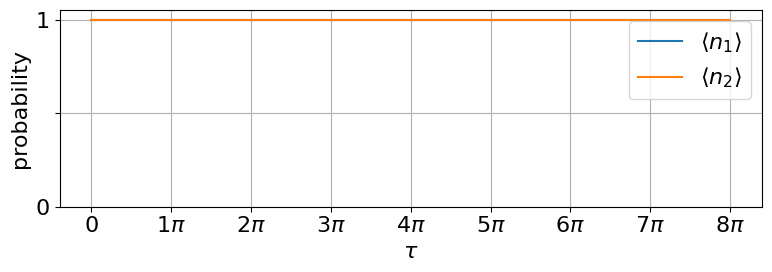

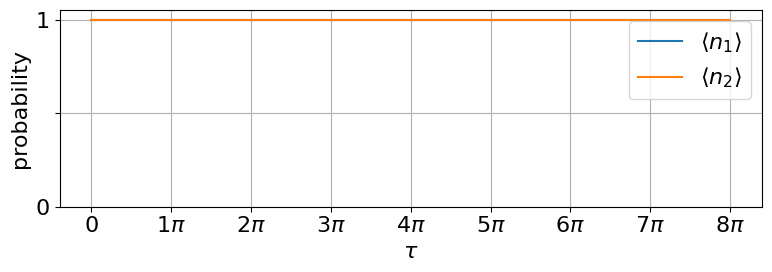

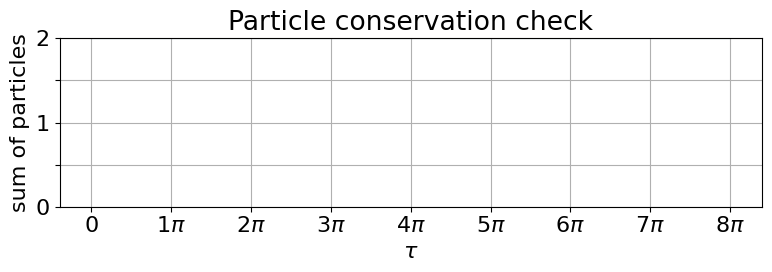

In [12]:
num_op_labels = [r"$\langle n_" + str(i+1) + "\\rangle$" for i in range(num_sites)]
xticks = np.linspace(0, 8*np.pi, 9)
xtick_labels = [r'${}\pi$'.format(i) if i != 0 else '0' for i in range(9)]

plt.figure(figsize=(8, 3))
plt.plot(times, n_t05_evo_matrix)
plt.xlabel(r"$\tau$")
plt.ylabel("probability")
#plt.title("Probability of occupying a given site")
plt.grid()
plt.legend(num_op_labels)
plt.yticks([0, 0.5, 1], ['0','', '1'])
plt.xticks(xticks, xtick_labels)
plt.tight_layout()
plt.savefig("figures/2-site-tb/ket00/t=05-site-prob.pdf")

plt.figure(figsize=(8, 3))
plt.plot(times, n_t1_evo_matrix)
plt.xlabel(r"$\tau$")
plt.ylabel("probability")
#plt.title("Probability of occupying a given site")
plt.grid()
plt.legend(num_op_labels)
plt.yticks([0,0.5, 1], ['0','', '1'])
plt.xticks(xticks, xtick_labels)
plt.tight_layout()
plt.savefig("figures/2-site-tb/ket00/t=1-site-prob-ket00.pdf")

plt.figure(figsize=(8, 3))
plt.plot(times, np.sum(n_t1_evo_matrix, axis=1))
plt.xlabel(r"$\tau$")
plt.ylabel("sum of particles")
plt.title("Particle conservation check")
plt.ylim([0, 2])
plt.yticks([0,0.5, 1, 1.5, 2], ['0','','1', '', '2'])
plt.xticks(xticks, xtick_labels)
plt.grid()
plt.tight_layout()
plt.savefig("figures/2-site-tb/ket00/t=1-particle-cons-check-ket00.pdf")
plt.show()

### Trotterization

In [13]:
from qiskit.opflow import Suzuki

def compute_U_trot(H, time, trotter_steps, order=1):
    U_trot = Suzuki(trotter_steps, order=order).convert(time * H)
    return U_trot

def trotter_evolution(H, observable, initial_state, times, num_sites, trotter_steps):
    evo_matrix_trot = np.zeros((len(times), num_sites))
    for i, time in enumerate(tqdm(times)):
        for j, oi in enumerate(observable):
            U = compute_U_trot(H, time, trotter_steps)
            final_state = U @ initial_state
            evo_matrix_trot[i, j] = np.abs(
                (final_state.adjoint() @ oi @ final_state).eval()
            )
    return evo_matrix_trot

# Time evolution calculation using same parameters as the exact classical calculation
# Initial state on the far left (same as before)
initial_state = One ^ Zero

# Define array of time points (technically these are relative to the hopping terms)
times = np.linspace(0, 8 * np.pi, 500)

evo_matrix_trot_5 = trotter_evolution(H_2, n_is, initial_state, times, num_sites, 5)
evo_matrix_trot_8 = trotter_evolution(H_2, n_is, initial_state, times, num_sites, 8)

 97%|█████████▋| 485/500 [00:04<00:00, 97.09it/s] 


KeyboardInterrupt: 

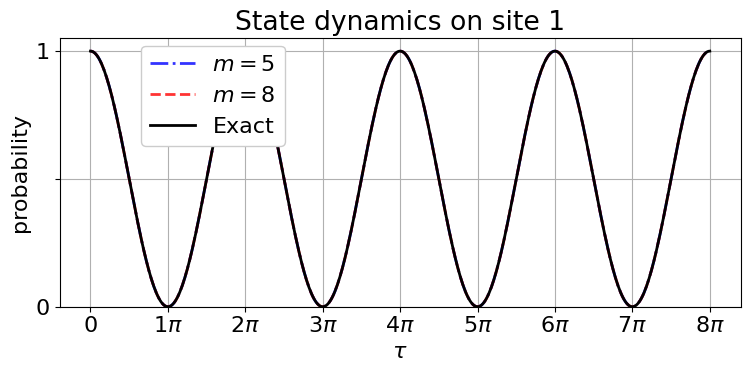

In [ ]:
# Plot state dynamics over one particular site
site = 0

plt.figure(figsize=(8, 4))
plt.plot(
    times,
    evo_matrix_trot_5[:, site],
    "b-.",
    linewidth=2,
    label=r"$m=5$",
    markerfacecolor="royalblue",
    alpha=0.8,
)
plt.plot(
    times,
    evo_matrix_trot_8[:, site],
    "r--",
    linewidth=2,
    label="$m=8$",
    markerfacecolor="salmon",
    alpha=0.8,
)
plt.plot(
    times, n_t1_evo_matrix[:, site], "k-", linewidth=2, label="Exact", markerfacecolor="grey"
)
plt.xlabel(r"$\tau$")
plt.ylabel("probability")
plt.ylim([0.0, 1.05])
plt.grid()
plt.legend(loc=(0.12, 0.6), framealpha=1)
plt.title("State dynamics on site " + str(site+1))
plt.tight_layout()
plt.yticks([0,0.5, 1], ['0','','1'])
plt.xticks(xticks, xtick_labels)
plt.savefig("figures/2-site-tb/t=1-3-state_dynm_site1.pdf")
plt.show()

### Draw circuit

In [ ]:
from qiskit.opflow import PauliTrotterEvolution

def convert_U_trot_to_qc(U_trot):

    qc_trot = PauliTrotterEvolution().convert(U_trot)
    return (
        qc_trot.to_circuit().decompose()#.decompose()
    )  # add decompose methods so gates are not abstracted unitary blocks
    
U1 = compute_U_trot(H_2, np.pi, 1)
qc = convert_U_trot_to_qc(U1)

latex_code = qc.draw("latex_source")
print(latex_code)
with open("circuits/2-site-circuit.tex", "w") as f:
    f.write(latex_code)

\documentclass[border=2px]{standalone}

\usepackage[braket, qm]{qcircuit}
\usepackage{graphicx}

\begin{document}
\scalebox{1.0}{
\Qcircuit @C=1.0em @R=1.0em @!R { \\
	 	\nghost{{q}_{0} :  } & \lstick{{q}_{0} :  } & \multigate{1}{\mathrm{R_{YY}}\,(\mathrm{\frac{-\pi}{2}})}_<<<{0} & \multigate{1}{\mathrm{R_{XX}}\,(\mathrm{\frac{-\pi}{2}})}_<<<{0} & \qw & \qw\\
	 	\nghost{{q}_{1} :  } & \lstick{{q}_{1} :  } & \ghost{\mathrm{R_{YY}}\,(\mathrm{\frac{-\pi}{2}})}_<<<{1} & \ghost{\mathrm{R_{XX}}\,(\mathrm{\frac{-\pi}{2}})}_<<<{1} & \qw & \qw\\
\\ }}
\end{document}
